In [1]:
from __future__ import print_function
from __future__ import division

import make_dictionaries
import os
import math
import params

import numpy as np
from astropy.io import fits
from astropy.table import Table
from scipy.stats import binned_statistic, scoreatpercentile
import pickle
from scipy.optimize import minimize
import time
from voronoi_2d_binning import voronoi_2d_binning
from sklearn.neighbors import NearestNeighbors

In [2]:
import binning
import bin_debiasing
import fit_debiasing

In [3]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

In [4]:
os.mkdir('output_files/') if os.path.isdir('output_files/') is False else None

In [5]:
source_directory = params.source_directory
save_directory = params.numpy_save_directory
full_sample = params.full_sample
volume_limited_sample = params.volume_limited_sample
question = params.question
bins_to_plot = params.bins_to_plot
print('Question to be debiased: {}'.format(question))

min_log_fv = -1.5
max_log_fv = 0.01

Question to be debiased: t01_smooth_or_features


In [6]:
full_data = Table.read(source_directory + full_sample)
print('Loaded galaxy data...')
questions = make_dictionaries.questions
print('Loaded questions...')
function_dictionary = make_dictionaries.function_dictionary
print('Loaded functions...')

Loaded galaxy data...
Loaded questions...
Loaded functions...


In [13]:
#for question in questions.keys():
    #for answer in questions[question]['answers']:
        #print(question + '_' + answer + '_weighted_fraction')
        
question = 't01_smooth_or_features'
answer = 'a02_features_or_disk'

In [42]:
def debias_by_fit(data,full_data,vbins,zbins,zbins_coarse,function_dictionary,min_log_fv):
    
    fit_setup = fit_debiasing.get_best_function(data,vbins,zbins_coarse,function_dictionary,
                                            question,answer,min_log_fv)
    
    fit_vbin_results = fit_debiasing.fit_vbin_function(data, vbins, zbins_coarse, fit_setup,
                                                   question,answer,min_log_fv)
    
    k_func,c_func = fit_debiasing.get_kc_functions(fit_vbin_results)
    
    kparams, cparams,dout, kmin, kmax, cmin, cmax = fit_debiasing.fit_mrz(fit_vbin_results, k_func,
                                                                      c_func,clip=2,plot=False)
    
    debiased_fit = fit_debiasing.debias(full_data,0.03, k_func,c_func, kparams, cparams,
                                    question,answer,kmin,kmax,cmin,cmax,fit_setup)
    # Debias ALL of the data 
    
    return debiased_fit,fit_vbin_results

In [49]:
# Calculate RMS of the volume limited sample: -----

def histogram_fractions(data,hist_bins):
    h,bin_edges = np.histogram(data,bins=hist_bins)
    f = h/np.sum(h)
    return f


def choose_best_function(vl_data,vl_fit,vl_bin,debiased_fit,debiased_bin):

    hist_bins = np.linspace(0,1,11)
    hist_bins[-1] = 2
    hist_bins[0] = -1

    # First divide the data into 10 redshift bins:
    z_range = [np.min(vl_data['REDSHIFT_1']),np.max(vl_data['REDSHIFT_1'])]
    z_bin_edges = np.linspace(z_range[0],z_range[1],11)
    z_bin_edges[0] = 0 # Ensure all data is binned
    z_bin_edges[-1] = 1 # Ensure all data is binned
    z_bin_assign = np.digitize(vl_data['REDSHIFT_1'],bins=z_bin_edges) # 10 bins

    low_z_reference = vl_data[z_bin_assign == 1][question + '_' + answer + '_weighted_fraction']

    rms_bin_array = np.zeros((10,10))
    rms_fit_array = np.zeros((10,10))

    f_reference = histogram_fractions(low_z_reference,hist_bins)

    for i,z_i in enumerate(np.unique(z_bin_assign)):
    
        high_z_select = z_bin_assign == z_i
        vl_fit_h = vl_fit[high_z_select]
        vl_bin_h = vl_bin[high_z_select]
    
        f_fit = histogram_fractions(vl_fit_h,hist_bins)
        f_bin = histogram_fractions(vl_bin_h,hist_bins)
    
        rms_fit_array[i] = np.absolute(f_fit - f_reference)
        rms_bin_array[i] = np.absolute(f_bin - f_reference)
    
    bin_residual = np.sum(rms_bin_array)/10
    fit_residual = np.sum(rms_fit_array)/10

    print('RMS residual from fitting method = {0:.3f}'.format(fit_residual))
    print('RMS residual from binning method = {0:.3f}'.format(bin_residual))

    if fit_residual > bin_residual:
        print('---> Binning method selected')
        debiased = debiased_bin.copy()
    else:
        print('---> Fitting method selected')
        debiased = debiased_fit.copy()
        
    return debiased

In [45]:
def reduce_sample(data,questions,question,p_cut=0.5,N_cut=5):
    
    # Get the reference sample from the previous data:
    
    previous_q = questions[question]['pre_questions']
    previous_a = questions[question]['pre_answers']
    
    if previous_q != None:
        p_col = data[question + '_' + '_debiased_rh']
        N_col = data[question + '_' + '_count']
        select = (p_col > p_cut) & (N_col >= N_cut)
        data_reduced = data[select]
        print('{}/{} galaxies with p>{} and N>={}.'.format(len(data_reduced),
                                                          len(data),p_cut,N_cut))
    
    else:
        data_reduced = data.copy()
        print('Primary question, so all {} galaxies used.'.format(len(data_reduced)))
    
    return data_reduced

In [53]:
def bin_and_debias(full_data,question,questions,answer):
    
    data = reduce_sample(full_data,questions,question)

    vbins,zbins,zbins_coarse,vbins_all,zbins_all,zbins_coarse_all,vbins_table = binning.bin_data(data,full_data,question,answer,plot=False,signal=100)
    
    debiased_bin = bin_debiasing.debias(data,vbins,zbins,question,answer)
    debiased_fit,fit_vbin_results = debias_by_fit(data,full_data,vbins,zbins,zbins_coarse,function_dictionary,min_log_fv)

    volume_ok = data['in_volume_limit'] == 1
    vl_data = full_data[volume_ok]
    vl_fit = debiased_fit[volume_ok]
    vl_bin = debiased_bin[volume_ok]

    debiased = choose_best_function(vl_data,vl_fit,vl_bin,debiased_fit,debiased_bin)

    data[question +'_' + answer + '_debiased_rh'] = debiased
    
    (os.mkdir('output_files/'+ question) if
     os.path.isdir('output_files/'+ question) is False else None)
    (os.mkdir('output_files/'+ question + '/' + answer) if
     os.path.isdir('output_files/'+ question + '/' + answer) is False else None)

    bin_table = Table([vbins,zbins,zbins_coarse],names=('vbin','zbin','coarse_zbin'))
    all_bin_table = Table([vbins_all,zbins_all,zbins_coarse_all],names=('vbin','zbin','coarse_zbin'))
    debiased_table = Table([debiased_bin,debiased_fit],names=('fit_method','bin_method'))

    bin_table.write('output_files/'+ question + '/' + answer + '/bins.fits',overwrite=True)
    debiased_table.write('output_files/'+ question + '/' + answer + '/debiased.fits',overwrite=True)
    fit_vbin_results.write('output_files/'+ question + '/' + answer + '/fit_results.fits',overwrite=True)
    vbins_table.write('output_files/'+ question + '/' + answer + '/vbin_parameters.fits',overwrite=True)

    return debiased

Primary question, so all 228201 galaxies used.
Bin-accretion...
2441  initial bins.
Reassign bad bins...
28  good bins.
Modified Lloyd algorithm...
26  iterations.
Unbinned pixels:  0  /  38374
Fractional S/N scatter (%): 10.244100466
28 voronoi bins
79.60714285714286 redshift bins per voronoi bin
All bins fitted! 20.614737272262573s in total
chisq(logistic) = 0.055703934100993724
All bins fitted! 18.98494577407837s in total
chisq(exp. power) = 0.028140701285528598
All bins fitted! 19.14583444595337s in total
RMS residual from fitting method = 0.329
RMS residual from binning method = 0.133
---> Binning method selected


FileNotFoundError: [Errno 2] No such file or directory: 'output_files/t01_smooth_or_features/a02_features_or_disk'

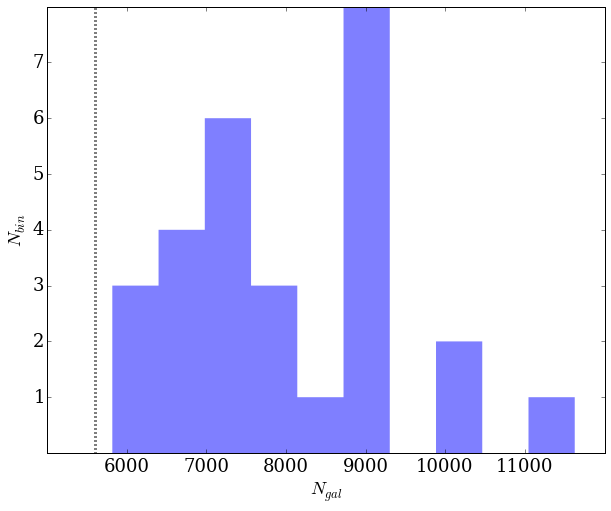

In [51]:
for question in questions.keys():
    for answer in questions[question]['answers']:
        bin_and_debias(full_data,question,questions,answer)